Here is some code where I am messing around with building a convolutional neural network using some examples from the internet. I've writted notes about how this needs to be modified for our analysis.

# Imports

Install tensorflow in your conda environment. Note that you need to have numpy-1.23.1. When I did this, I had to manually uninstall numpy-1.24.3 then install numpy-1.23.1, before installing tensorflow. The tensorflow install failed to install numpy-1.23.1, itself, even though it told me it was successful.

In [237]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_gnn as tfgnn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sn
import neural_structured_learning as nsl
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler

# Get data

Download the mnist data base from https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz then load in the data. For me, keras wasn't able to automatically download the data so I had to go to the url and download the data by hand before loading the data, as shown below.

In [238]:
# Download the mnist data base from: https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz
# Load data with keras
path = 'mnist.npz'
(X_train, y_train) , (X_test, y_test) = keras.datasets.mnist.load_data(path)
len(X_train), len(X_test), X_train[0].shape
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

(60000, 10000, (28, 28))

The data are 2D greyscale images of handwritten numbers with intensity in the range 0-255. The data must be rescaled by dividing by 255, then flattened into 1D arrays.

In our case, we will be using 1D 'images' and the range will be between 0 and the maximum height reached within any one of the pulses. We don't know what this is ahead of time; you'll have to find the maximum then divide all the images by that number. I think we will also need to pad the arrays to make them the same length, since each pulse will have a variable number of samples. I would start by adding zeroes evenly to the front and back of the array. I'm not sure if the way we do this could introduce some difficulties in learning for the CNN. We should think about this a little bit.

number 5


(<matplotlib.image.AxesImage at 0x3d1136250>, None)

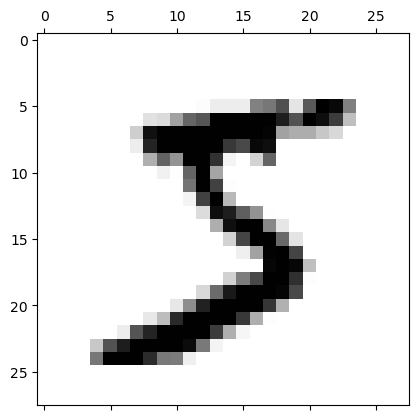

In [239]:
plt.matshow(X_train[0],cmap='binary'), print('number %i'%y_train[0])

In [240]:
X_train = X_train/255
X_test = X_test/255

X_train_flattened = X_train.reshape(len(X_train),28*28)
X_test_flattened = X_test.reshape(len(X_test),28*28)
#X_val_flattened = X_val.reshape(len(X_val),28*28)

X_train_flattened[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

# Sequential fully-connected neural network with only input and output layers

This is a sequential fully-connected neural network with only input and output layers. The input shape is (784,) because each 28x28 image has been flattened into a 784x1 tensor. Each element of the tensor is fed into one of the 784 neurons of the input layer. The output shape is 10 because there are 10 different numbers that can be written in the image: 0, 1, 2, 3, 4, 5, 6, 7, 8, or 9. The term "sequential" indicates the model is a plain stack of layers, which works in a basic scenario where every layer has a single input tensor and a single output tensor. The term "fully-connected" refers to the fact that each one of the 784 input neurons is connected to each one of the 10 output neurons. Generally, the activation function for the output layer is a sigmoid that scales the output of each neuron to within the range 0-1. This makes it appear to be a probability, but I think it's not a probability and we shouldn't call it that.

The configuration described above can be adapted to our case. The input shape will be the paded length of the waveforms, the output shape will be 3 for a 0 (signal-like), 1 (gate-like), or 2 (cathode-like) S2.

Some resources for learning or remembering what a neural network does are: https://victorzhou.com/blog/intro-to-neural-networks/ (simple description of a neural network) and https://keras.io/guides/sequential_model/ (basic description of how to write the code using keras). You may already have experience with this from your courses - I'm not sure what they teach these days - but it's not a big deal if you have no experience because there are lots of resources online.

In [241]:
simpleNN = keras.Sequential([
    keras.layers.Dense(10,input_shape=(784,),activation='sigmoid')
])

simpleNN.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_75 (Dense)            (None, 10)                7850      
                                                                 
Total params: 7850 (30.66 KB)
Trainable params: 7850 (30.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The loss function for multi-class classification should be sparse categorical crossentropy. This will work for our case as well, since we have 3 categories. We could also try a case were we have an output shape of 2  with 0 = signal-like and 1 = gate/cathode-like, using binary crossentropy. Was there any similar issue with the hyperparameters for the multiclass boosted decision tree.

In [242]:
simpleNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

One epoch corresponds to running the data through the neural network, calculating the loss, and reweighting the model. We will have to weight the samples evenly across S2 size, like  we did for the boosted decision tree. I think this is done by setting the paramter sample_weight equal to your sample weights in the fit function, below. We will also have to decide how many epochs to use by plotting accuracy vs epoch, as you've done for the boosted decision tree, and comparing the accuracy of the test and training datasets, which should be the ~same at the end if you aren't overtraining.

In [243]:
hist_simpleNN = simpleNN.fit(X_train_flattened,y_train,epochs=5, validation_split=0.2, shuffle=True)

Epoch 1/5
1500/1500 [==============================] - 8s 5ms/step - loss: 0.5116 - accuracy: 0.8685 - val_loss: 0.3176 - val_accuracy: 0.9126
Epoch 2/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.3173 - accuracy: 0.9120 - val_loss: 0.2842 - val_accuracy: 0.9202
Epoch 3/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2938 - accuracy: 0.9178 - val_loss: 0.2801 - val_accuracy: 0.9211
Epoch 4/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2809 - accuracy: 0.9211 - val_loss: 0.2695 - val_accuracy: 0.9252
Epoch 5/5
1500/1500 [==============================] - 7s 4ms/step - loss: 0.2735 - accuracy: 0.9227 - val_loss: 0.2683 - val_accuracy: 0.9265


In [244]:
simpleNN.evaluate(X_test_flattened,y_test)
print(X_test_flattened.shape)
print(y_test.shape)

313/313 [==============================] - 2s 4ms/step - loss: 0.2725 - accuracy: 0.9245
(10000, 784)
(10000,)


It's also nice to plot a confusion matrix to understand what is getting misclassified. This might be good to do making cuts on S2 size, especially if the accuracy vs epoch plot shows that some S2 sizes are improving while others are not.

In [245]:
y_predicted = simpleNN.predict(X_test_flattened)
y_predicted_label = [np.argmax(i) for i in y_predicted]

y_predicted[0], y_predicted_label[0]

313/313 [==============================] - 0s 1ms/step


(array([2.3866329e-02, 4.1430192e-07, 5.1901214e-02, 9.4336361e-01,
        1.7335346e-03, 5.6131057e-02, 1.3233030e-06, 9.9963903e-01,
        8.6022109e-02, 6.9532180e-01], dtype=float32),
 7)

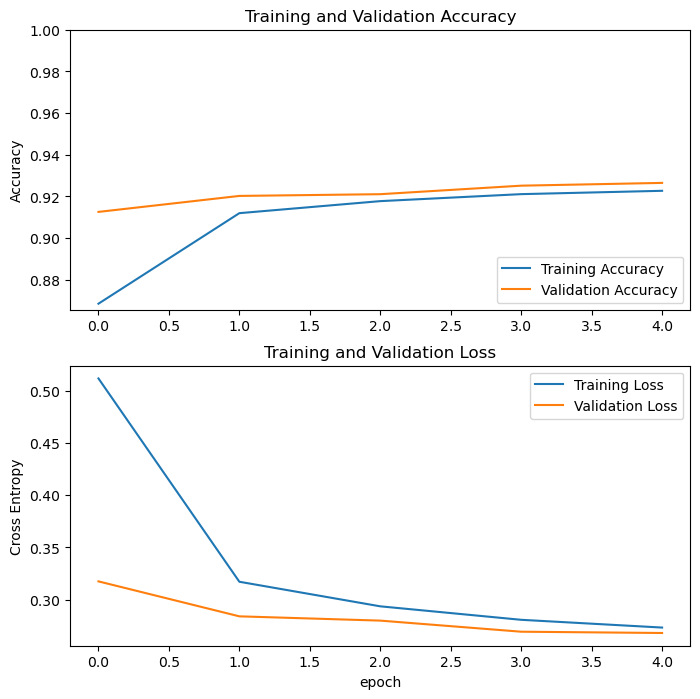

In [268]:
acc = hist_simpleNN.history['accuracy']
val_acc = hist_simpleNN.history['val_accuracy']

loss = hist_simpleNN.history['loss']
val_loss = hist_simpleNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Text(95.72222222222221, 0.5, 'Truth')

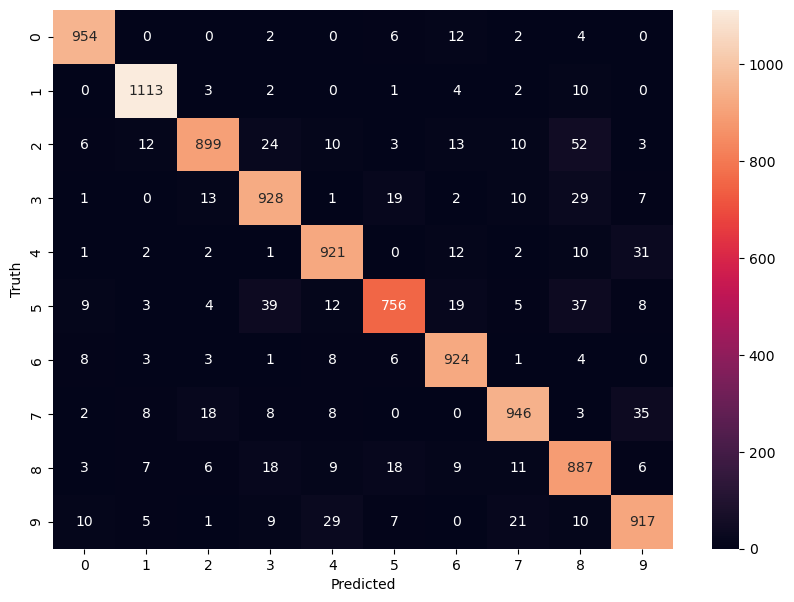

In [246]:
plt.figure(figsize = (10,7))
sn.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_label),
           annot=True, 
           fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Adding a hidden layer

Adding a hidden layer can increase performance but will take longer to run. We'll have to think about how to optimize the number of hidden layers and the number of neurons in each hidden layer. Below, there is one hidden layer with 100 neurons. The activation function is a rectified linear unit (ReLU), which helps to improve performance. Hidden layers usually have ReLU or Leaky ReLU functions.

In [247]:
hiddenNN = keras.Sequential([
    keras.layers.Dense(100,input_shape=(784,),activation='relu'),
    keras.layers.Dense(10,activation='sigmoid')
])
hiddenNN.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_76 (Dense)            (None, 100)               78500     
                                                                 
 dense_77 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79510 (310.59 KB)
Trainable params: 79510 (310.59 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [248]:
hiddenNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

hist_hiddenNN = hiddenNN.fit(X_train_flattened,y_train,epochs=5, validation_split=0.2, shuffle=True)

Epoch 1/5
1500/1500 [==============================] - 9s 5ms/step - loss: 0.3876 - accuracy: 0.8885 - val_loss: 0.2901 - val_accuracy: 0.9198
Epoch 2/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3132 - accuracy: 0.9117 - val_loss: 0.2884 - val_accuracy: 0.9212
Epoch 3/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3074 - accuracy: 0.9149 - val_loss: 0.3084 - val_accuracy: 0.9164
Epoch 4/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3115 - accuracy: 0.9129 - val_loss: 0.2951 - val_accuracy: 0.9233
Epoch 5/5
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3177 - accuracy: 0.9135 - val_loss: 0.3069 - val_accuracy: 0.9164


In [249]:
hiddenNN.evaluate(X_test_flattened,y_test)

313/313 [==============================] - 2s 5ms/step - loss: 0.3249 - accuracy: 0.9091


[0.32486578822135925, 0.9090999960899353]

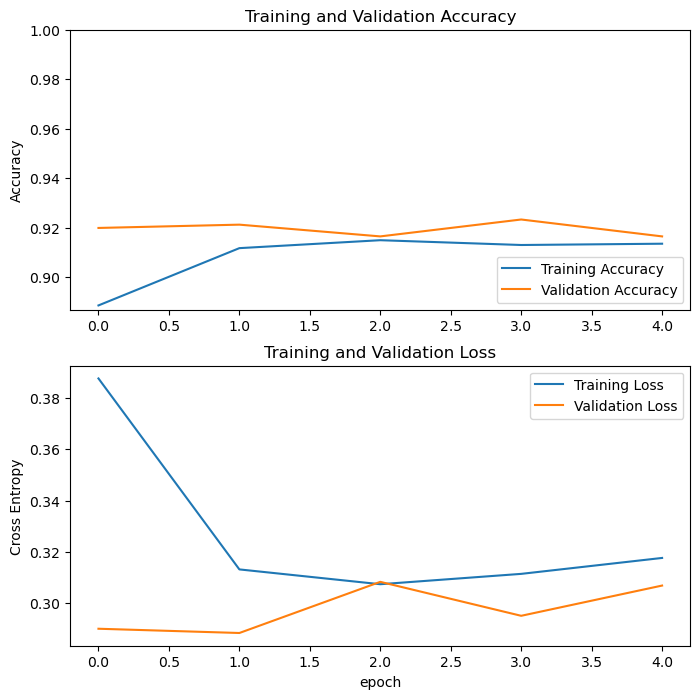

In [267]:
acc = hist_hiddenNN.history['accuracy']
val_acc = hist_hiddenNN.history['val_accuracy']

loss = hist_hiddenNN.history['loss']
val_loss = hist_hiddenNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Convolutional neural network

Convolutional layers should improve the accuracy further but will even longer to run. You should try to understand what filters, pooling, and kernal size are. These are the hyperparameters you need to mess around with, as well as the number of convolutional layers. The filters will be used to look for certain features of the S2 waveforms so I think the kernal size should be decided based on the size of features you are trying to select. Here is a descriptive link: https://www.simplilearn.com/tutorials/deep-learning-tutorial/convolutional-neural-network#:~:text=A%20convolutional%20neural%20network%20is,classify%20objects%20in%20an%20image. This made my computer start to overheat, hence the desire to use a gpu, but maybe we are okay.

In [280]:
convoNN = keras.Sequential([
    keras.layers.Conv2D(filters=28,kernel_size=(3,3),activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [281]:
convoNN.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy', 'MeanSquaredError'])

In [282]:
hist_convoNN = convoNN.fit(X_train, y_train, epochs=500, validation_split=0.2, shuffle=True)

Epoch 1/500
1500/1500 [==============================] - 17s 10ms/step - loss: 0.1837 - accuracy: 0.9440 - mean_squared_error: 27.3724 - val_loss: 0.0832 - val_accuracy: 0.9755 - val_mean_squared_error: 27.4448
Epoch 2/500
1500/1500 [==============================] - 14s 9ms/step - loss: 0.0827 - accuracy: 0.9762 - mean_squared_error: 27.3787 - val_loss: 0.1160 - val_accuracy: 0.9733 - val_mean_squared_error: 27.4461
Epoch 3/500
1500/1500 [==============================] - 14s 10ms/step - loss: 0.0847 - accuracy: 0.9794 - mean_squared_error: 27.3796 - val_loss: 0.1051 - val_accuracy: 0.9816 - val_mean_squared_error: 27.4471
Epoch 4/500
1500/1500 [==============================] - 15s 10ms/step - loss: 0.1492 - accuracy: 0.9780 - mean_squared_error: 27.3803 - val_loss: 0.2558 - val_accuracy: 0.9758 - val_mean_squared_error: 27.4475
Epoch 5/500
1500/1500 [==============================] - 14s 9ms/step - loss: 0.2620 - accuracy: 0.9784 - mean_squared_error: 27.3806 - val_loss: 0.6547 - va

In [283]:
convoNN.evaluate(X_test,y_test)

313/313 [==============================] - 4s 7ms/step - loss: 5239242.0000 - accuracy: 0.9665 - mean_squared_error: 27.3403


[5239242.0, 0.9664999842643738, 27.340312957763672]

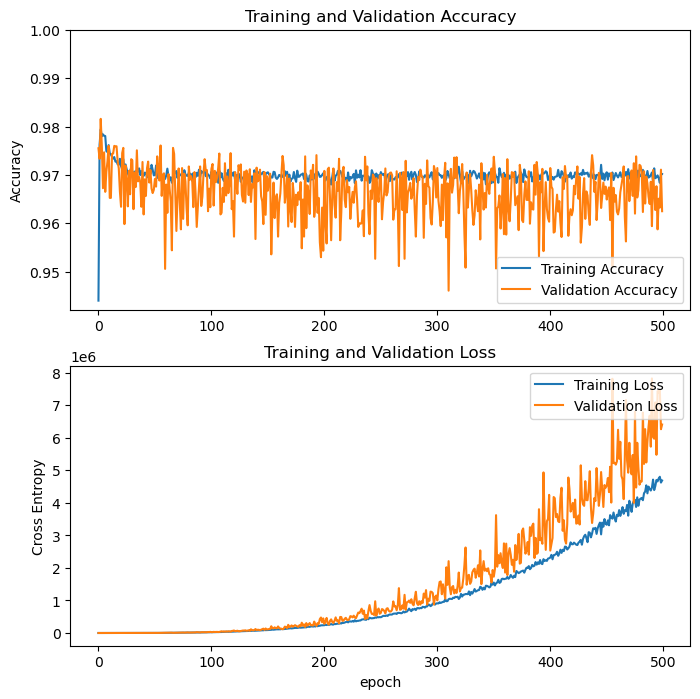

In [284]:
acc = hist_convoNN.history['accuracy']
val_acc = hist_convoNN.history['val_accuracy']

loss = hist_convoNN.history['loss']
val_loss = hist_convoNN.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Convolutional Neural Network with Adversarial Learning

Having a play, thought this might be an interesting extension. Will use the same convoNN model setup as before for fair comparison.

In [274]:
# set up convolution neural net in the same way as before

cNN = keras.Sequential([
    keras.layers.Conv2D(filters=28,kernel_size=(3,3),activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Conv2D(filters=64,kernel_size=(3, 3),activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

In [275]:
# wrap the model with adversarial regularization

adv_config = nsl.configs.make_adv_reg_config(multiplier=0.2, adv_step_size=0.05)
adv_cNN = nsl.keras.AdversarialRegularization(cNN, adv_config=adv_config)

In [276]:
# compile, train and evaluate

adv_cNN.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])#, 'MeanSquaredError'])

In [277]:
hist_adv_cNN = adv_cNN.fit(x={'feature': X_train, 'label': y_train}, epochs=50, validation_split=0.2, shuffle=True)

Epoch 1/50
1500/1500 [==============================] - 28s 17ms/step - loss: 0.1977 - sparse_categorical_crossentropy: 0.1629 - sparse_categorical_accuracy: 0.9497 - scaled_adversarial_loss: 0.0347 - val_loss: 0.0772 - val_sparse_categorical_crossentropy: 0.0631 - val_sparse_categorical_accuracy: 0.9829 - val_scaled_adversarial_loss: 0.0141
Epoch 2/50
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0775 - sparse_categorical_crossentropy: 0.0632 - sparse_categorical_accuracy: 0.9809 - scaled_adversarial_loss: 0.0143 - val_loss: 0.0685 - val_sparse_categorical_crossentropy: 0.0559 - val_sparse_categorical_accuracy: 0.9847 - val_scaled_adversarial_loss: 0.0126
Epoch 3/50
1500/1500 [==============================] - 23s 15ms/step - loss: 0.0730 - sparse_categorical_crossentropy: 0.0594 - sparse_categorical_accuracy: 0.9834 - scaled_adversarial_loss: 0.0136 - val_loss: 0.0873 - val_sparse_categorical_crossentropy: 0.0712 - val_sparse_categorical_accuracy: 0.9822 - val_

In [278]:
adv_cNN.evaluate(x={'feature': X_test, 'label': y_test})

313/313 [==============================] - 7s 15ms/step - loss: 1363.9929 - sparse_categorical_crossentropy: 1127.8276 - sparse_categorical_accuracy: 0.9785 - scaled_adversarial_loss: 236.1650


[1363.992919921875, 1127.82763671875, 0.9785000085830688, 236.1650390625]

Adversarial training seems to improve things slightly

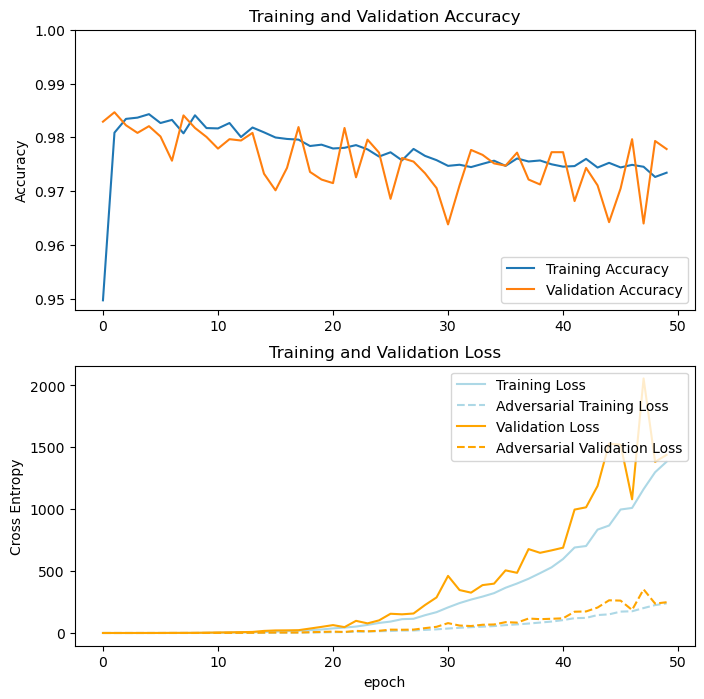

In [279]:
acc = hist_adv_cNN.history['sparse_categorical_accuracy']
val_acc = hist_adv_cNN.history['val_sparse_categorical_accuracy']

loss = hist_adv_cNN.history['loss']
adv_loss = hist_adv_cNN.history['scaled_adversarial_loss']
val_loss = hist_adv_cNN.history['val_loss']
val_adv_loss = hist_adv_cNN.history['val_scaled_adversarial_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='lightblue')
plt.plot(adv_loss, label='Adversarial Training Loss', color='lightblue', linestyle='dashed')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.plot(val_adv_loss, label='Adversarial Validation Loss', color='orange', linestyle='dashed')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()